# Position based xT

# Setup

In [1]:
import json
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mplsoccer import Pitch
from scipy.stats import binned_statistic_2d

In [2]:
notebook_directory = os.getcwd()
course_directory = notebook_directory.rsplit("/Notebooks")[0]
os.chdir(course_directory)

# Data

In [3]:
df = pd.DataFrame()

for i in range(13):
    with open(f"data/wyscout/events_England_{i+1}.json") as file:
        data = json.load(file)    
    df = pd.concat([df, pd.DataFrame(data)])

df

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,85,177959171
1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,83,177959172
2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,6.542188,82,177959173
3,8,Head pass,[{'id': 1801}],120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",2499719,Pass,1609,1H,8.143395,82,177959174
4,8,Simple pass,[{'id': 1801}],167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",2499719,Pass,1609,1H,10.302366,85,177959175
...,...,...,...,...,...,...,...,...,...,...,...,...
43145,5,Ball out of the field,[],0,"[{'y': 32, 'x': 0}, {'y': 100, 'x': 100}]",2500098,Interruption,1623,2H,2796.732525,50,251596409
43146,3,Corner,"[{'id': 302}, {'id': 801}, {'id': 1801}]",70965,"[{'y': 100, 'x': 100}, {'y': 47, 'x': 88}]",2500098,Free Kick,1633,2H,2829.821084,30,251596232
43147,1,Air duel,"[{'id': 701}, {'id': 1802}]",7919,"[{'y': 53, 'x': 12}, {'y': 50, 'x': 14}]",2500098,Duel,1623,2H,2831.211419,10,251596410
43148,1,Air duel,"[{'id': 703}, {'id': 1801}]",8005,"[{'y': 47, 'x': 88}, {'y': 50, 'x': 86}]",2500098,Duel,1633,2H,2832.434399,10,251596234


## Step 1 to calculate xT : actions to move the ball.

In [4]:
next_event = df.shift(-1, fill_value=0)
df["next_event"] = next_event["subEventName"]
df["kickedOut"] = df.apply(lambda x: 1 if x["next_event"] == "Ball out of the field" else 0, axis=1)
move_df = df.loc[df["subEventName"].isin(['Simple pass', 'High pass', 'Head pass', 'Smart pass', 'Cross'])]
pass_index = move_df[move_df["kickedOut"] == 1].index
move_df = move_df.drop(pass_index)
move_df["x"] = move_df.positions.apply(lambda cell: (cell[0]['x']) * 105/100)
move_df["y"] = move_df.positions.apply(lambda cell: (100 - cell[0]['y']) * 68/100)
move_df["end_x"] = move_df.positions.apply(lambda cell: (cell[1]['x']) * 105/100)
move_df["end_y"] = move_df.positions.apply(lambda cell: (100 - cell[1]['y']) * 68/100)
move_df_with_coords = move_df.loc[(((move_df["end_x"] != 0) & (move_df["end_y"] != 68)) & ((move_df["end_x"] != 105) & (move_df["end_y"] != 0)))]

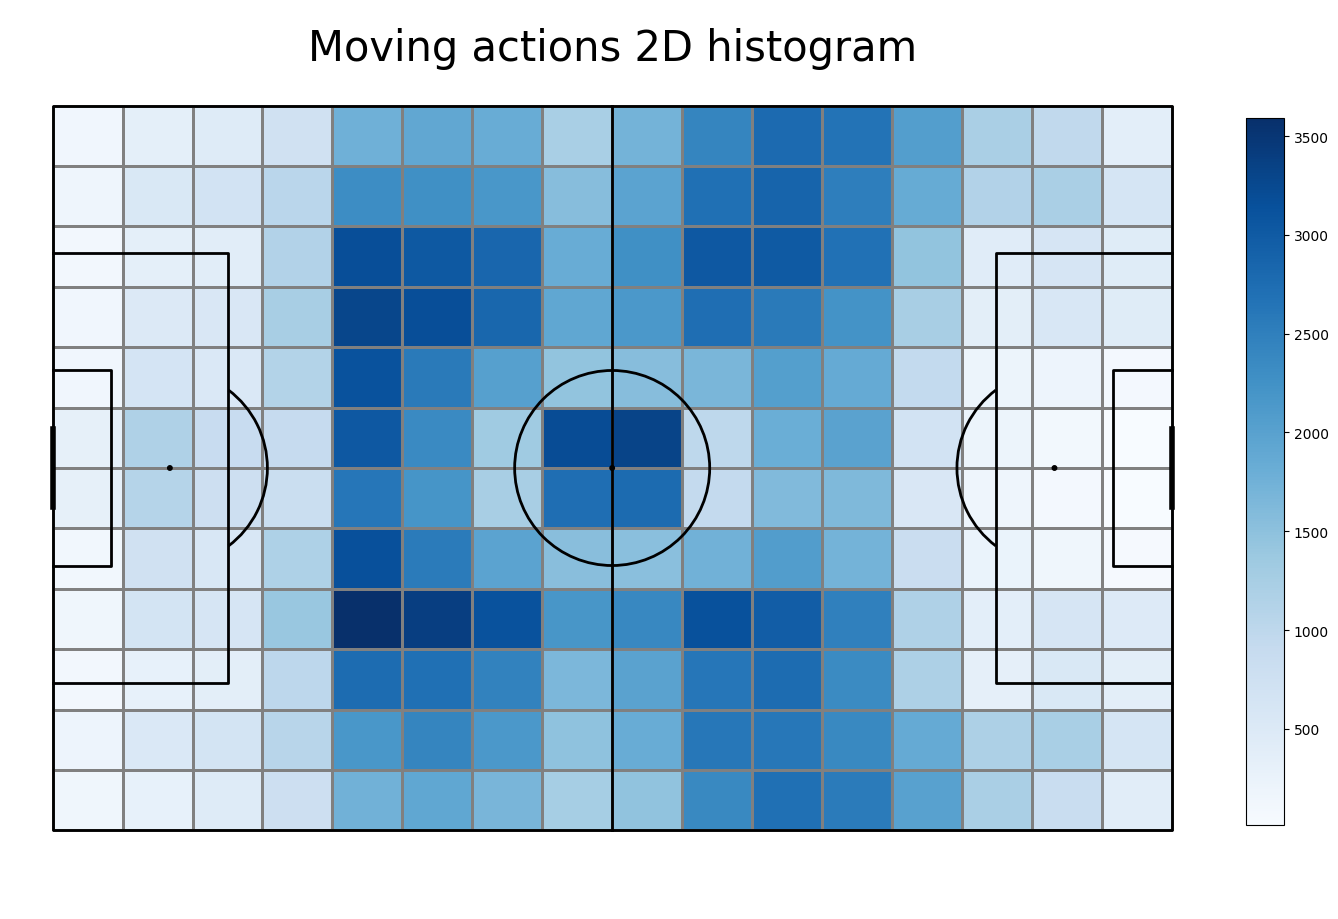

In [5]:
pitch = Pitch(line_color="black", pitch_type="custom", pitch_length=105, pitch_width=68, line_zorder=2)
move = pitch.bin_statistic(move_df["x"], move_df["y"], statistic="count", bins=(16,12), normalize=False)

fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, endnote_height=0.04, title_space=0, endnote_space=0)
pcm  = pitch.heatmap(move, cmap='Blues', edgecolor='grey', ax=ax['pitch'])
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)

fig.suptitle("Moving actions 2D histogram", fontsize=30)
plt.show();

move_count = move["statistic"]

# Step 2 to calculate xT : Shots

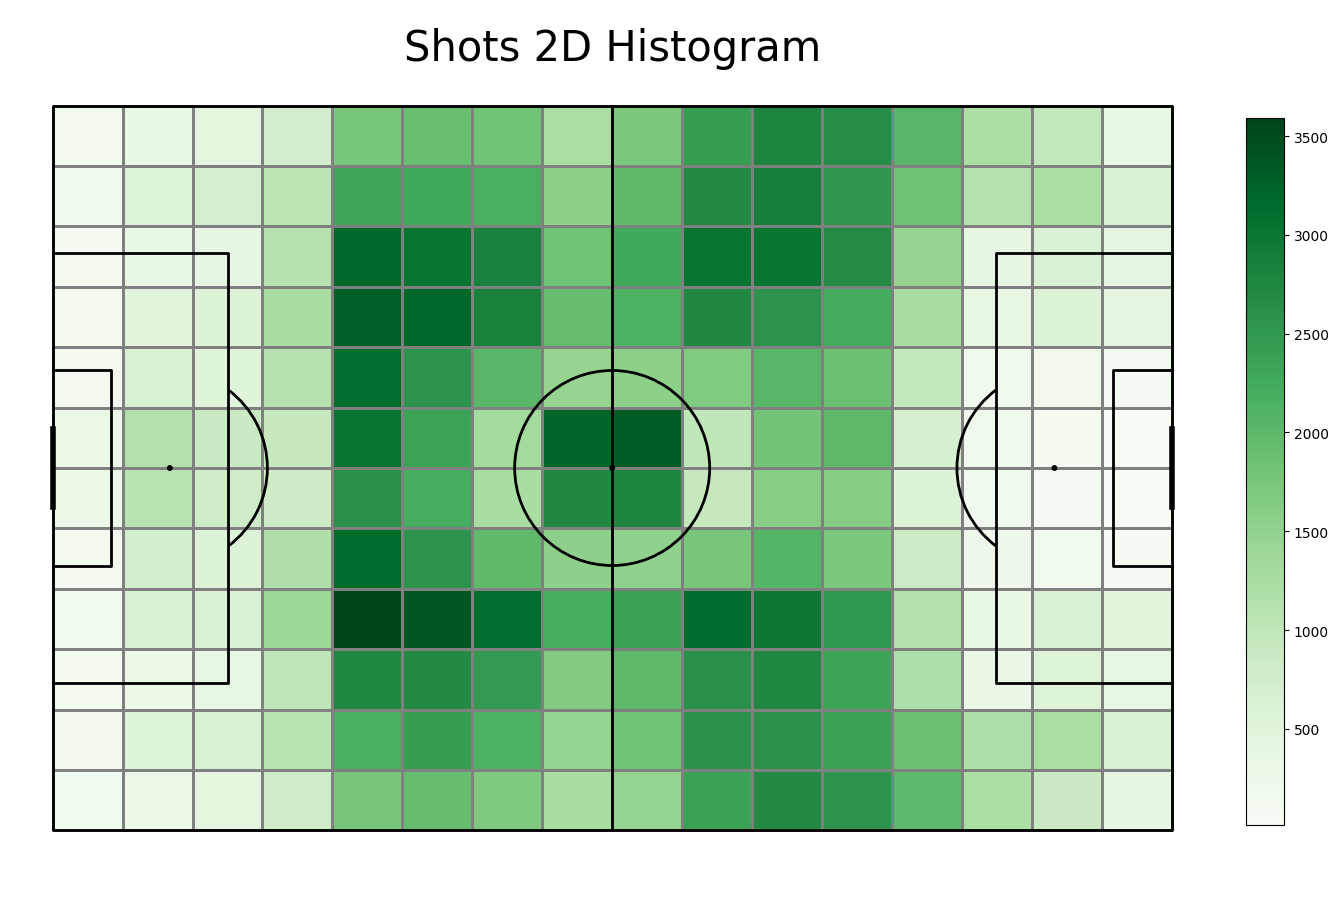

In [6]:
shot_df = df.loc[df["subEventName"] == "Shot"].copy()
shot_df["x"] = shot_df["positions"].apply(lambda cell: (cell[0]["x"]) * 105/100)
shot_df["y"] = shot_df["positions"].apply(lambda cell: (100 - cell[0]["y"]) * 68/100)

shot = pitch.bin_statistic(shot_df["x"], shot_df["y"], statistic="count", bins=(16,12), normalize=False)

fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, endnote_height=0.04, title_space=0, endnote_space=0)
pcm  = pitch.heatmap(move, cmap='Greens', edgecolor='grey', ax=ax['pitch'])
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)

fig.suptitle("Shots 2D Histogram", fontsize=30)
plt.show();

shot_count = shot["statistic"]

# Step 3 to calculate xT: Goals

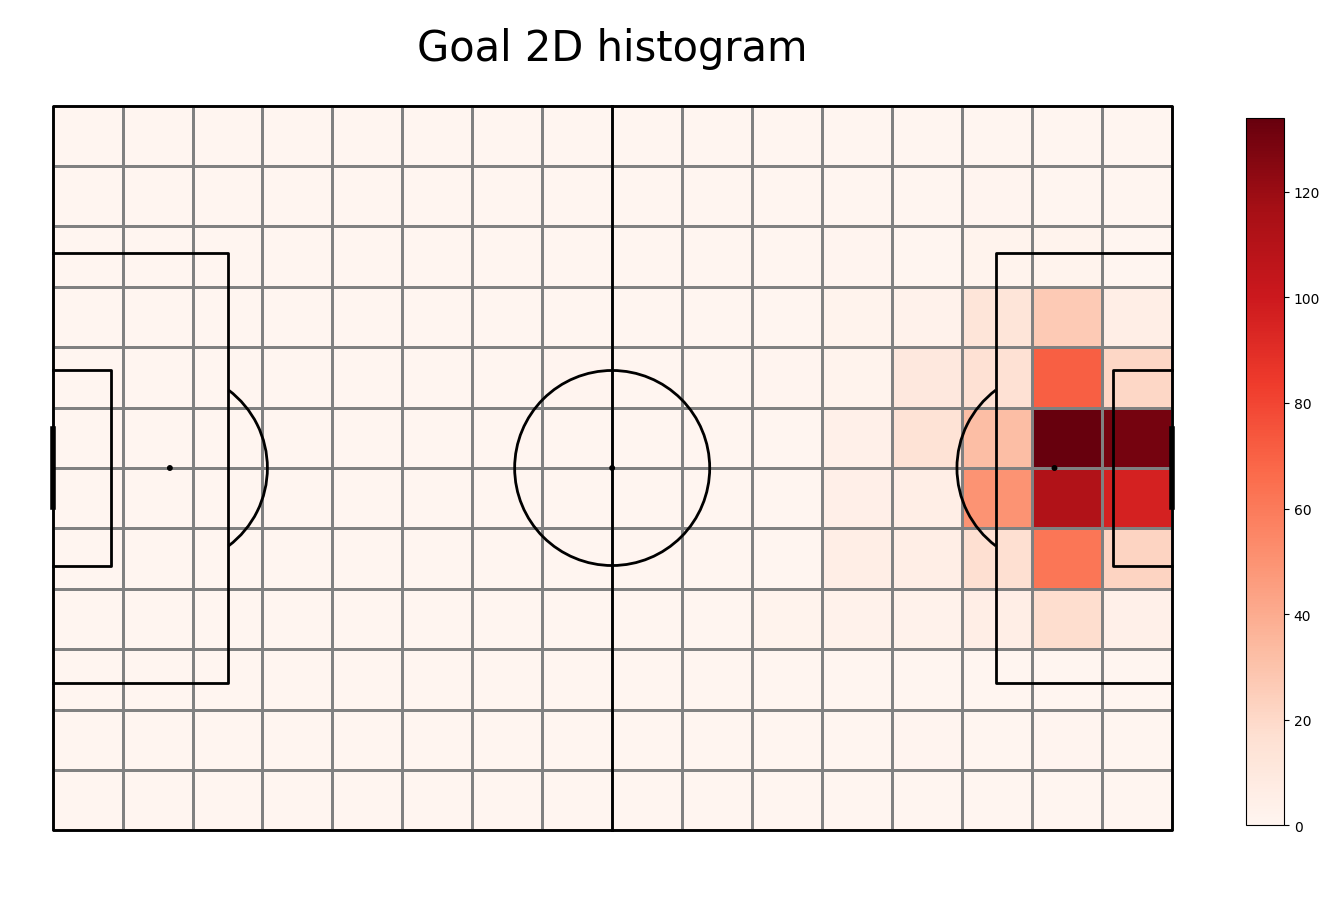

In [7]:
goal_df  = shot_df.loc[shot_df.apply(lambda x: {'id':101} in x.tags, axis = 1)]
goal = pitch.bin_statistic(goal_df.x, goal_df.y, statistic='count', bins=(16, 12), normalize=False)
goal_count = goal["statistic"]

fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, endnote_height=0.04, title_space=0, endnote_space=0)
pcm  = pitch.heatmap(goal, cmap='Reds', edgecolor='grey', ax=ax['pitch'])
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)

fig.suptitle('Goal 2D histogram', fontsize = 30)

plt.show();

# Step 4 to calculate xT : Move probability

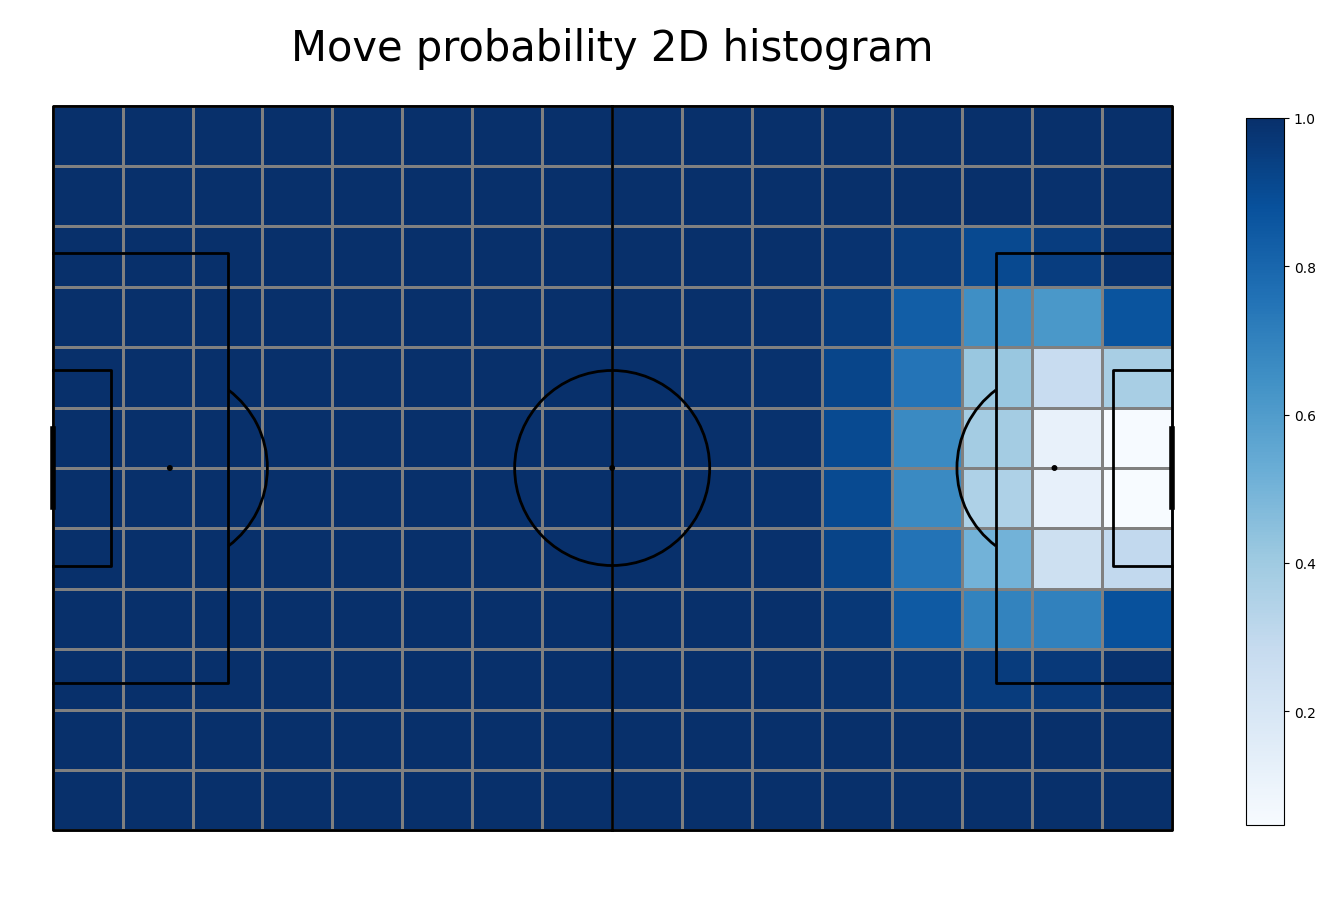

In [8]:
move_probability = move_count / (move_count +  shot_count)
move["statistic"] = move_probability

fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, endnote_height=0.04, title_space=0, endnote_space=0)
pcm = pitch.heatmap(move, cmap="Blues", edgecolor="grey", ax=ax["pitch"])
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)  

fig.suptitle("Move probability 2D histogram", fontsize=30)
plt.show();

# Step 5 to calculate xT: Shot Probability

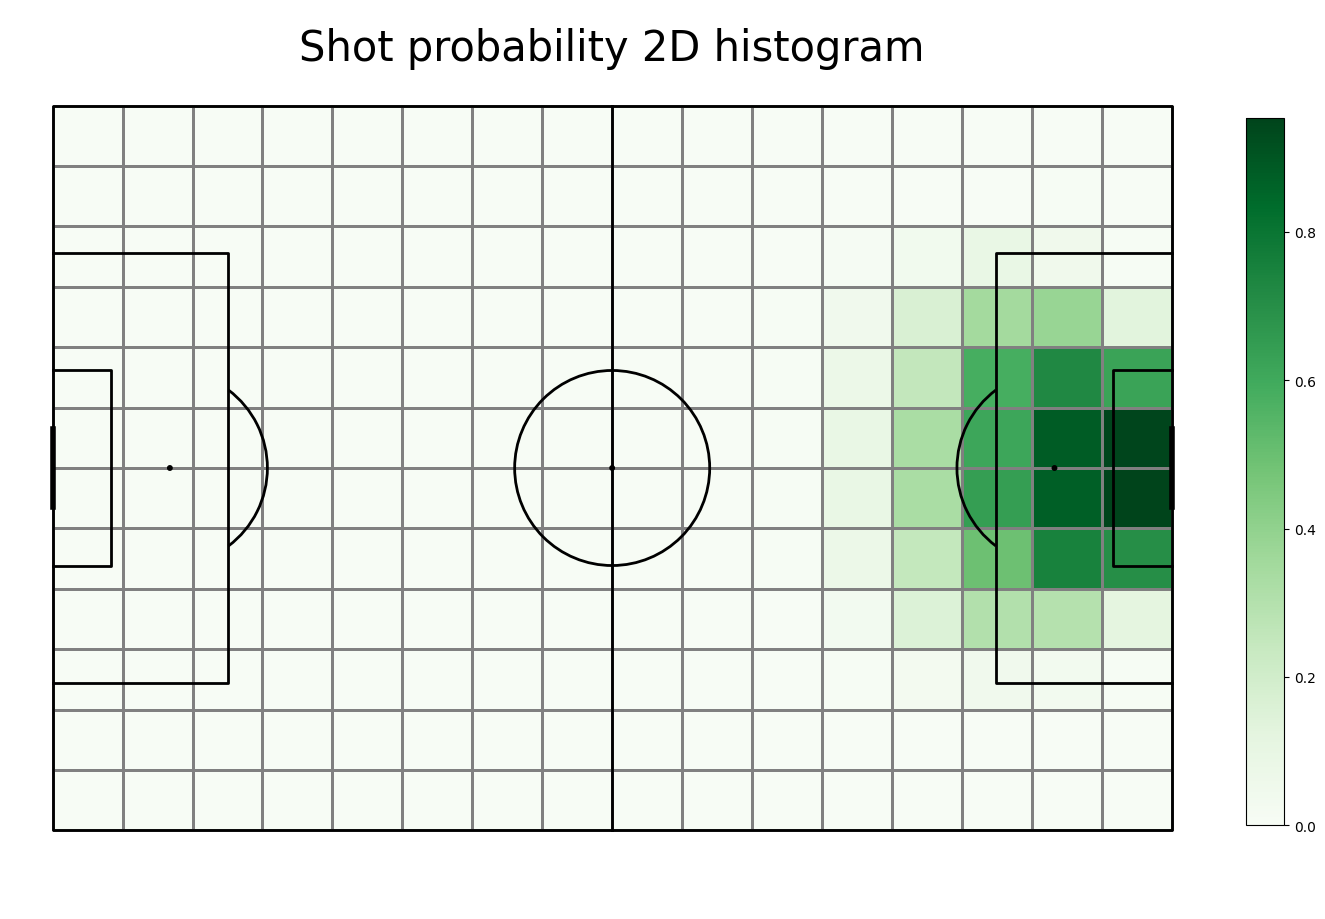

In [9]:
shot_probability = shot_count / (move_count +  shot_count)
shot["statistic"] = shot_probability

fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, endnote_height=0.04, title_space=0, endnote_space=0)
pcm = pitch.heatmap(shot, cmap="Greens", edgecolor="grey", ax=ax["pitch"])
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)  

fig.suptitle("Shot probability 2D histogram", fontsize=30)
plt.show();

# Step 6 to calculate xT: Goal Probability
- Ideally xG would be used but, this will be a simplified model for now.

/var/folders/9d/gkyqvpm50h9dr1t_4gy_88l00000gn/T/ipykernel_38447/3425206482.py:1: RuntimeWarning: invalid value encountered in divide
  goal_probability = goal_count/shot_count


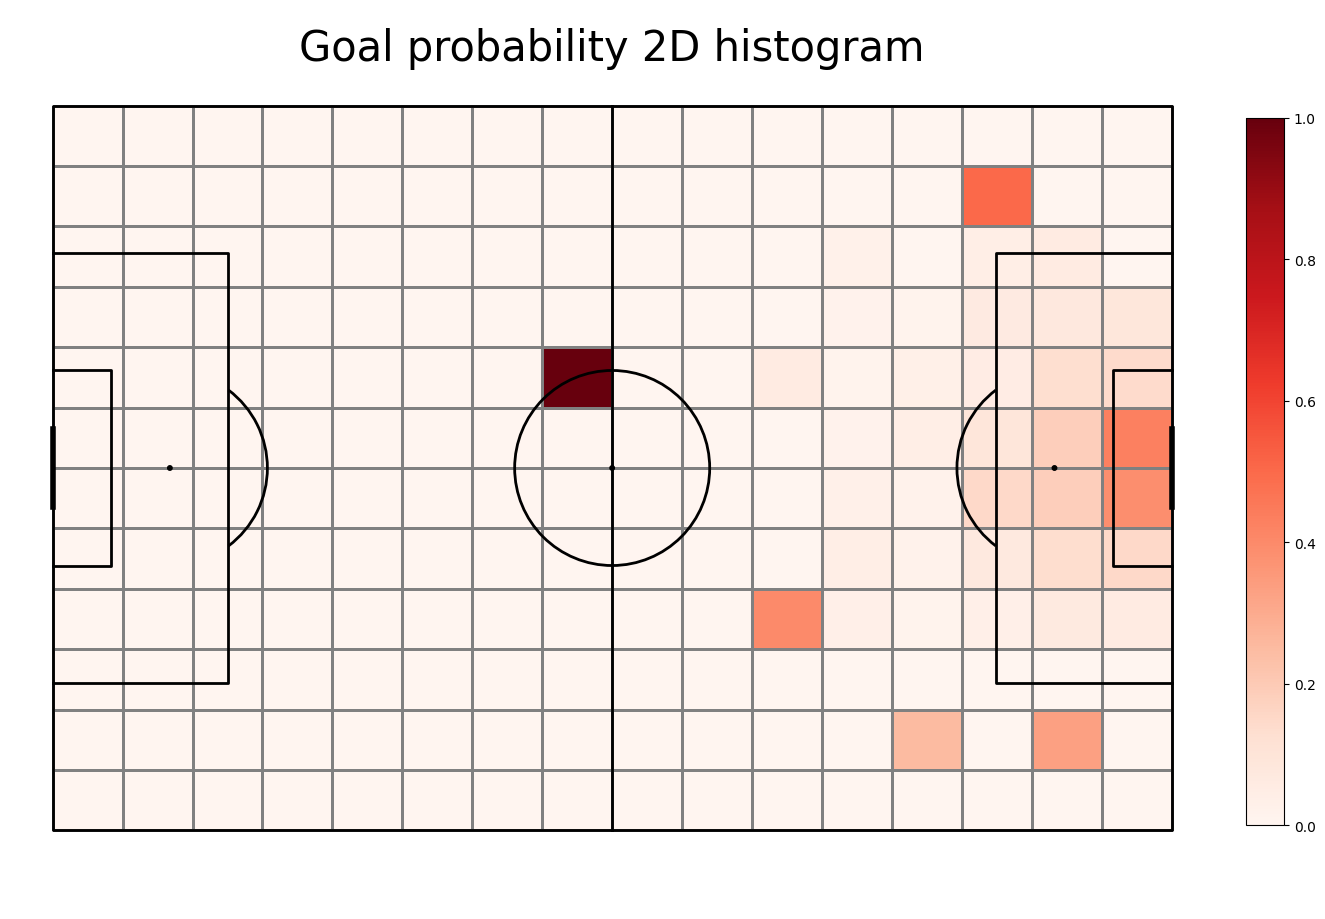

In [10]:
goal_probability = goal_count/shot_count
goal_probability[np.isnan(goal_probability)] = 0

fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, endnote_height=0.04, title_space=0, endnote_space=0)
goal["statistic"] = goal_probability

pcm = pitch.heatmap(goal, cmap="Reds", edgecolor="grey", ax=ax["pitch"])
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)

fig.suptitle("Goal probability 2D histogram", fontsize=30)
plt.show();

# Step 7 to calculate xT: Transition Matrices
- For each of the 192 squares (16*12), we need to calculate a transition matrix. This will tell us the probability of going from one zone to another.

In [15]:
move_df["start_sector"] = move_df.apply(lambda row: tuple([i[0] for i in binned_statistic_2d(np.ravel(row["x"]), np.ravel(row["y"]),
                                                               values = "None", statistic="count",
                                                               bins=(16, 12), range=[[0, 105], [0, 68]],
                                                               expand_binnumbers=True)[3]]), axis = 1)

move_df["end_sector"] = move_df.apply(lambda row: tuple([i[0] for i in binned_statistic_2d(np.ravel(row["end_x"]), np.ravel(row["end_y"]),
                                                               values = "None", statistic="count",
                                                               bins=(16, 12), range=[[0, 105], [0, 68]],
                                                               expand_binnumbers=True)[3]]), axis = 1)